In [1]:
import numpy as np
import matplotlib.pyplot as plt

from algorithms.MOEAD import moead, default_weight_vectors
import algorithms.MOEAD.evolutionary_operators as moead_operators

from algorithms.risk_measures import *

from data_loader import load_stock_quotations

%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 5]

# Load data

In [2]:
stock_quotations = load_stock_quotations()

delta_t = 90
stock_returns = stock_quotations.xs('close', level=1, axis=1).pct_change()
last_returns = stock_returns[-delta_t-1:-1]

stock_returns_mean = last_returns.mean() # predicted return for next day

# variance as risk
stock_returns_var = last_returns.var() # risk
stock_returns_cov = last_returns.cov() # covariance matrix

# semi-variance as risk
stock_returns_semi_var = semi_variance(last_returns)
stock_returns_semi_cov = semi_covariance_matrix(np.array(last_returns))

number_of_stocks = stock_returns.shape[1]

# Objective function

In [3]:
def portfolio_return_value(X):
    return X @ stock_returns_mean


def portfolio_risk_var(X):
    return np.diag(X @ stock_returns_cov @ X.T)


def portfolio_risk_semi_var(X):
    return np.diag(X @ stock_returns_semi_cov @ X.T)


def portfolio_objective_function(risk_function=portfolio_risk_semi_var,
                                 return_function=portfolio_return_value):
    return lambda X: np.c_[risk_function(X), -return_function(X)]

# Test

In [4]:
def show_results(stock_risk, objective_function, moead_kwargs):
    plt.xlabel('Risk')
    plt.ylabel('Return')
    plt.title(f"MOEA/D: iterations: {moead_kwargs['number_of_iterations']}, normalized: {moead_kwargs['normalize']}\n")
    plt.scatter(stock_risk, stock_returns_mean, c='gray', label='Basic stocks')

    moead_result = moead(objective_function=objective_function,
                         chromosome_length=number_of_stocks,
                         **moead_kwargs)

    pareto_front_moead = objective_function(moead_result)

    plt.scatter(pareto_front_moead[:,0], -pareto_front_moead[:,1], c='r', label='MOEA/D')

    plt.legend()
    plt.show()

## Normalization

MOEA/D: 100%|██████████| 200/200 [00:54<00:00,  3.65it/s]


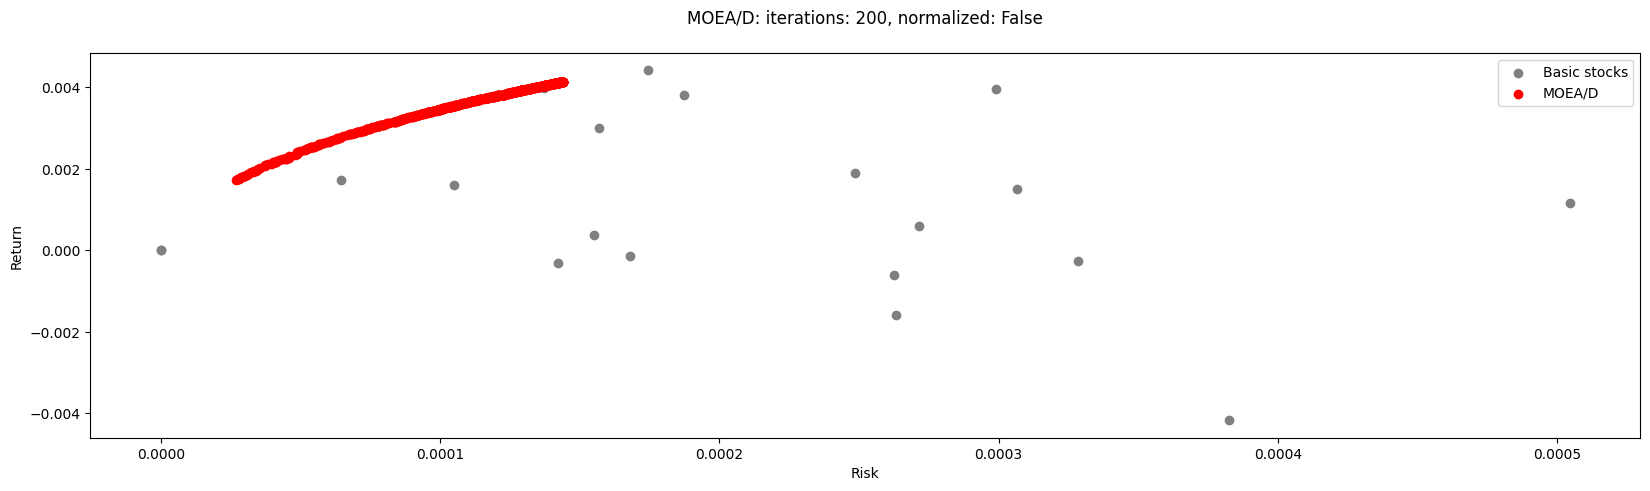

In [5]:
show_results(stock_risk=stock_returns_semi_var,
             objective_function=portfolio_objective_function(risk_function=portfolio_risk_semi_var),
             moead_kwargs={'number_of_iterations': 200,
                           'weight_vectors': default_weight_vectors(120),
                           'neighborhood_size': 20,
                           'mutation_probability': 0.2,
                           'normalize': False,
                           'crossover_operator': moead_operators.single_point_crossover,
                           'mutation_operator': moead_operators.swap_mutation})

MOEA/D: 100%|██████████| 200/200 [01:48<00:00,  1.85it/s]


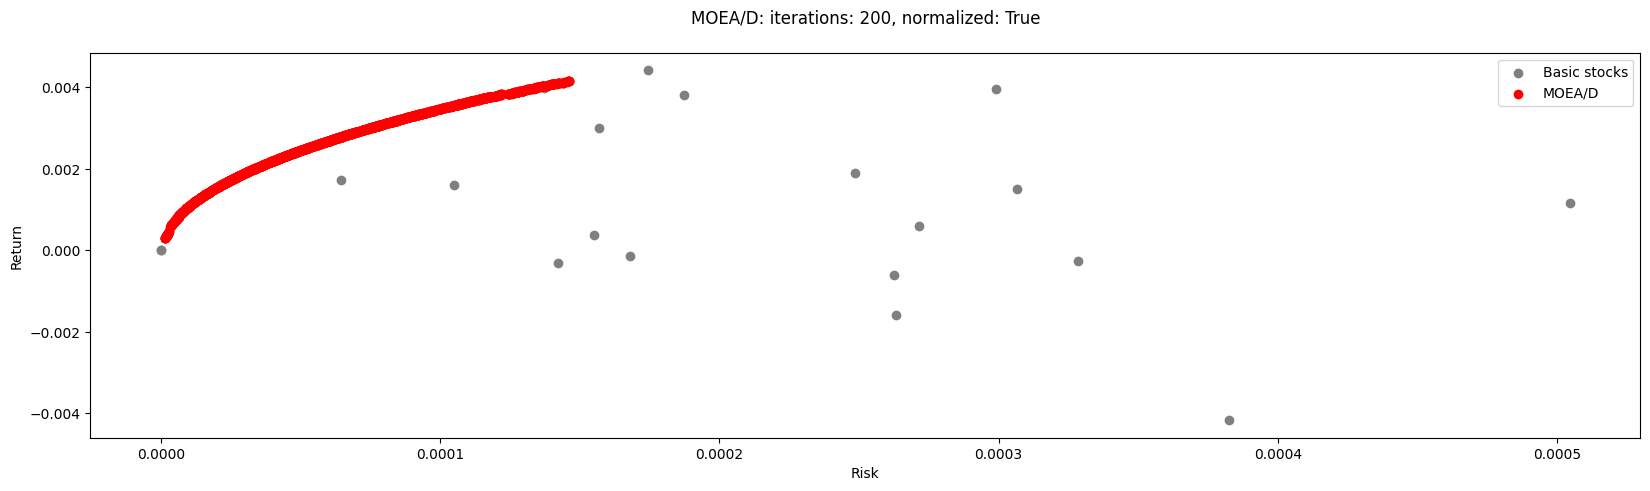

In [6]:
show_results(stock_risk=stock_returns_semi_var,
             objective_function=portfolio_objective_function(risk_function=portfolio_risk_semi_var),
             moead_kwargs={'number_of_iterations': 200,
                           'weight_vectors': default_weight_vectors(120),
                           'neighborhood_size': 20,
                           'mutation_probability': 0.2,
                           'normalize': True,
                           'crossover_operator': moead_operators.single_point_crossover,
                           'mutation_operator': moead_operators.swap_mutation})

## Different operators

### Crossover

MOEA/D: 100%|██████████| 200/200 [01:09<00:00,  2.88it/s]


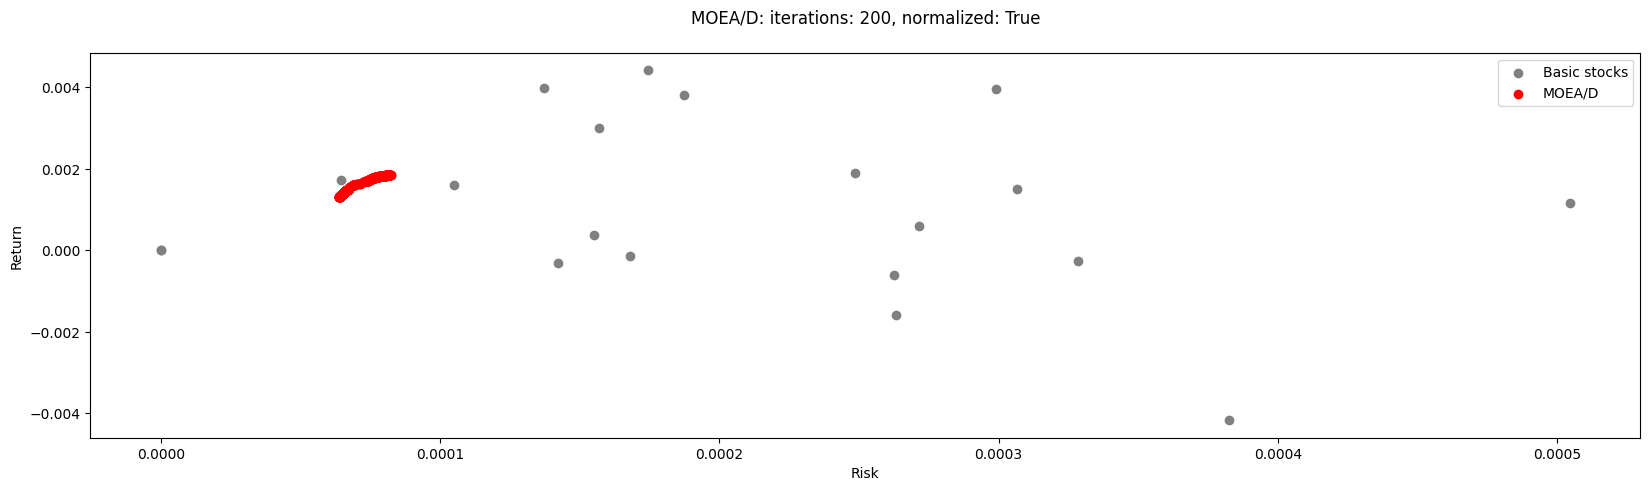

In [13]:
show_results(stock_risk=stock_returns_semi_var,
             objective_function=portfolio_objective_function(risk_function=portfolio_risk_semi_var),
             moead_kwargs={'number_of_iterations': 200,
                           'weight_vectors': default_weight_vectors(120),
                           'neighborhood_size': 20,
                           'mutation_probability': 0.2,
                           'normalize': True,
                           'crossover_operator': moead_operators.arithmetic_crossover,
                           'mutation_operator': moead_operators.swap_mutation})

MOEA/D: 100%|██████████| 200/200 [01:25<00:00,  2.35it/s]


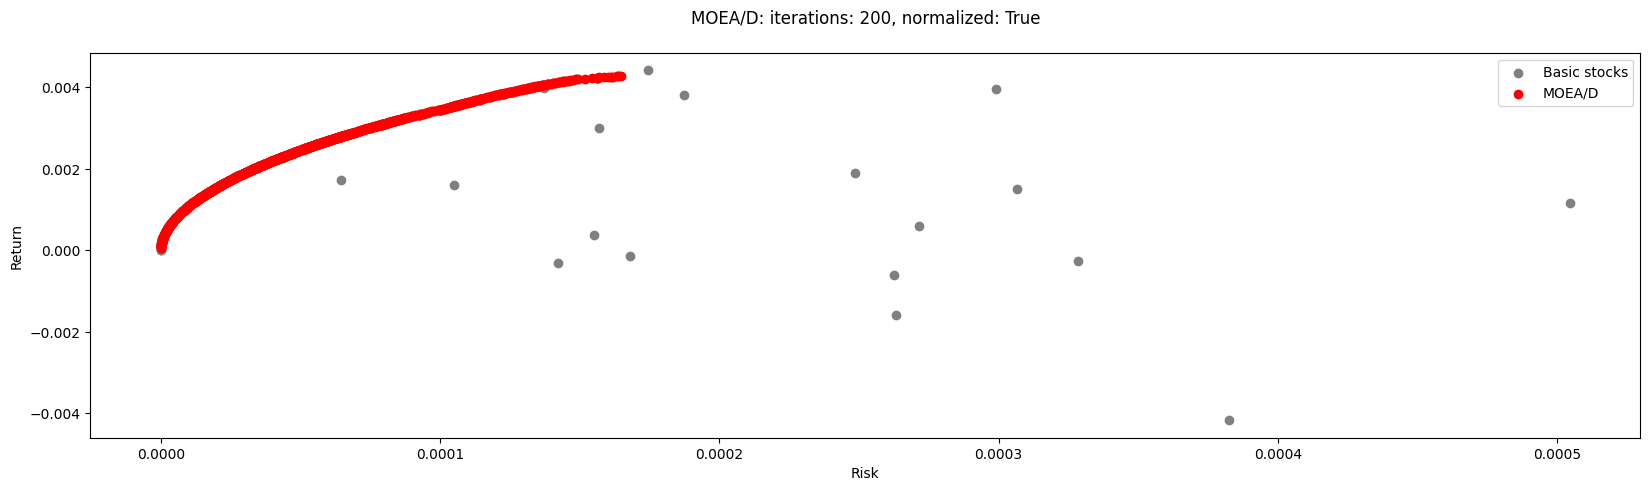

In [12]:
show_results(stock_risk=stock_returns_semi_var,
             objective_function=portfolio_objective_function(risk_function=portfolio_risk_semi_var),
             moead_kwargs={'number_of_iterations': 200,
                           'weight_vectors': default_weight_vectors(120),
                           'neighborhood_size': 20,
                           'mutation_probability': 0.2,
                           'normalize': True,
                           'crossover_operator': moead_operators.differential_crossover,
                           'mutation_operator': moead_operators.swap_mutation})

### Mutation

MOEA/D: 100%|██████████| 200/200 [01:45<00:00,  1.90it/s]


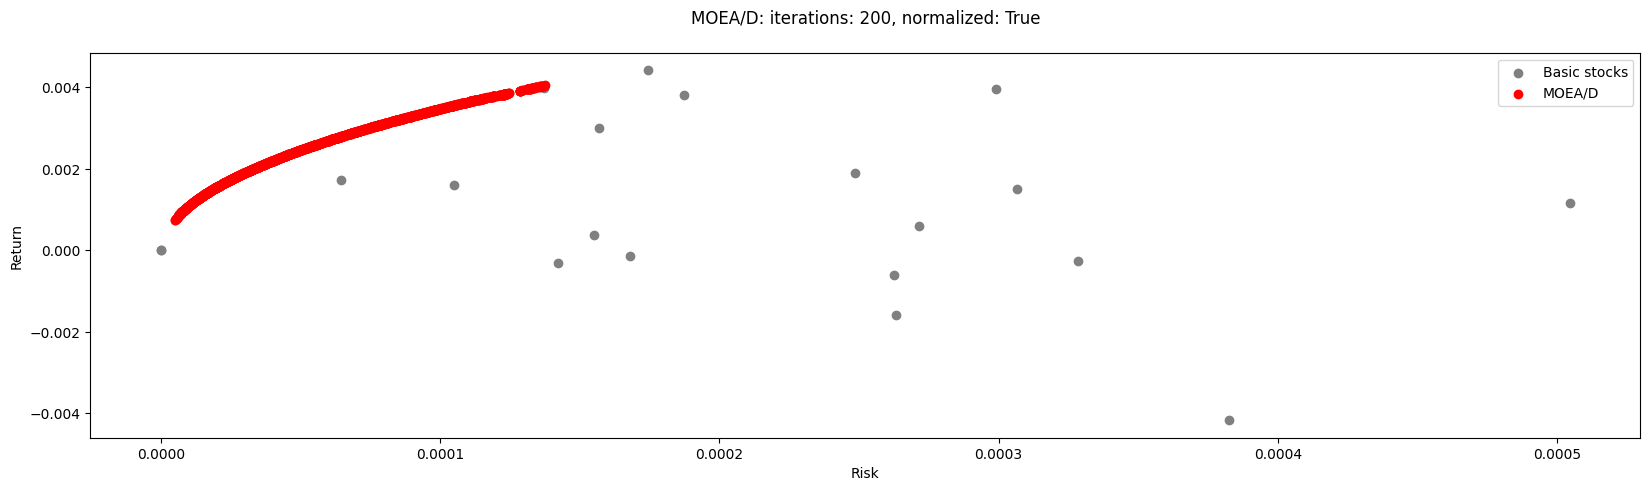

In [6]:
show_results(stock_risk=stock_returns_semi_var,
             objective_function=portfolio_objective_function(risk_function=portfolio_risk_semi_var),
             moead_kwargs={'number_of_iterations': 200,
                           'weight_vectors': default_weight_vectors(120),
                           'neighborhood_size': 20,
                           'mutation_probability': 0.2,
                           'normalize': True,
                           'crossover_operator': moead_operators.single_point_crossover,
                           'mutation_operator': moead_operators.change_pair_mutation})

MOEA/D: 100%|██████████| 200/200 [01:56<00:00,  1.72it/s]


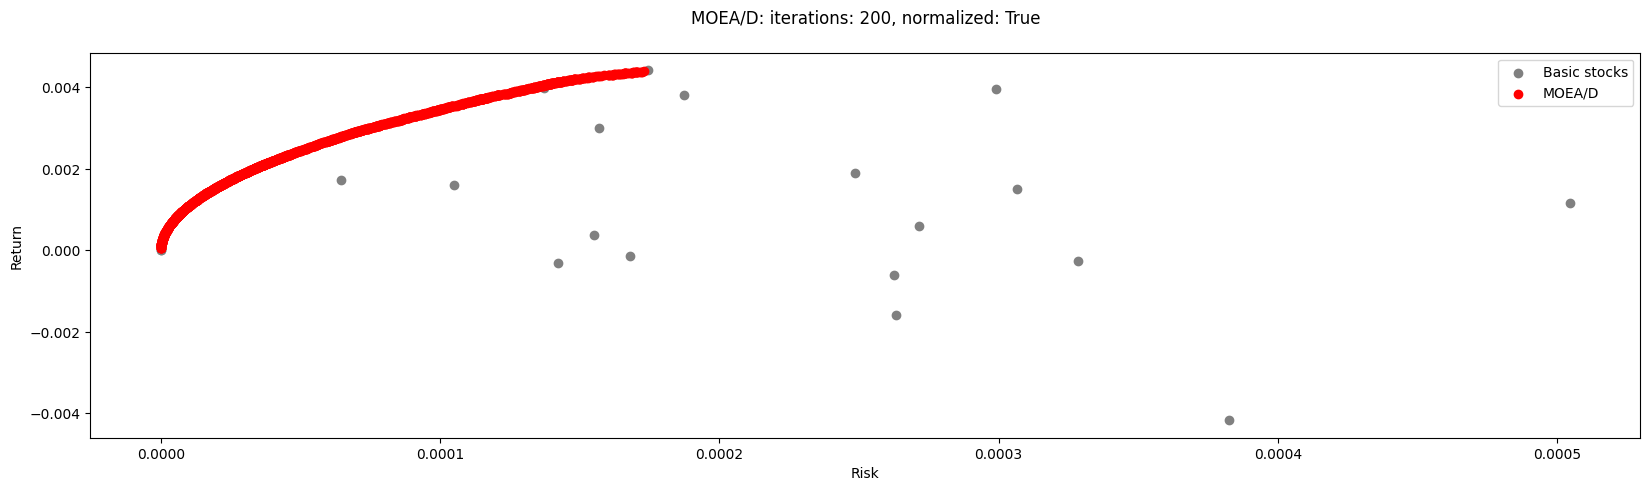

In [7]:
show_results(stock_risk=stock_returns_semi_var,
             objective_function=portfolio_objective_function(risk_function=portfolio_risk_semi_var),
             moead_kwargs={'number_of_iterations': 200,
                           'weight_vectors': default_weight_vectors(120),
                           'neighborhood_size': 20,
                           'mutation_probability': 0.2,
                           'normalize': True,
                           'crossover_operator': moead_operators.differential_crossover,
                           'mutation_operator': moead_operators.change_pair_mutation})